### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.patches as patches
import os
import string
from Metrics import get_num_clusters
from matplotlib.colors import ListedColormap
# from generate_imgs import vispy_export_png

# To allow pytorch and plt to co-exist
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
fontsize = 22

custom_params = {"axes.spines.right": False, "axes.spines.top": False,
                  "axes.labelsize": fontsize, "xtick.labelsize": fontsize,"ytick.labelsize": fontsize,
                  "legend.fontsize": fontsize, "legend.title_fontsize": fontsize,
                "lines.linewidth": 3, "figure.figsize": (10, 8),}

sns.set_theme(style="ticks", rc=custom_params)


def save_fig(fig, name, folder):
    
    if not folder.endswith("/"):
        folder += "/"

    if not name.endswith(".pdf"):
        name += ".pdf"

    try:
      os.mkdir(folder)
      print('Note: Made new folder')
    except:
        pass
    
    fig.savefig(folder + name, bbox_inches="tight", format='pdf')

main_folder     = "../../Thesis_TeX/Figures/"
incomp_folder   = "../../Thesis_TeX/Figures_incomplete/"

cuda


### Potential for different values of $S = 0.5 , 1$

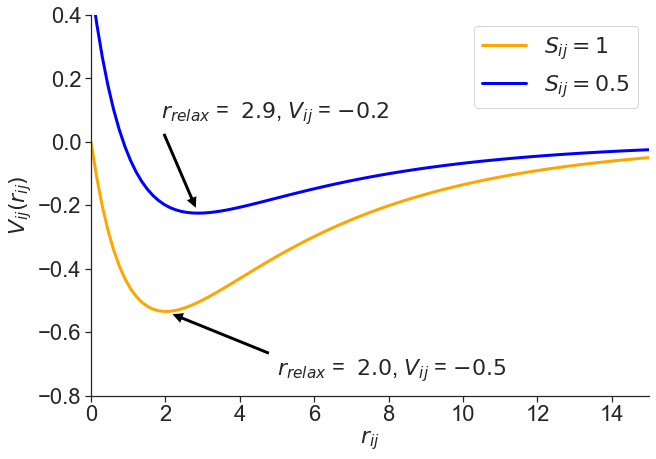

In [174]:
def pot(x, S, b = 5):
    return np.exp(-x) - S*np.exp(-x/5)

def pot_min(S, b = 5):
    return ( b * np.log(b/S) / (b - 1) )

min_05 = pot_min(0.5)
min_1 = pot_min(1)
min05_val = pot(min_05, 0.5)
min1_val = pot(min_1, 1)


fig, ax = plt.subplots(figsize=(10, 7))
x_plot = np.linspace(0, 15, 100)

plt.plot(x_plot, pot(x_plot, 1), label='$S_{ij} = 1$', c='orange')
plt.plot(x_plot, pot(x_plot, 0.5), label='$S_{ij} = 0.5$', c='blue')
# plt.vlines(min_05, -0.7, min05_val, linestyle='dashed', color='blue')
#make dashed arrow
plt.annotate(f'$r_{{relax}}$ =  ${min_05:.1f}$, $V_{{ij}}$ = ${min05_val:.1f}$', xy=(min_05, min05_val), xytext=(min_05 - 1, min05_val + 0.3),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=fontsize)
# plt.vlines(min_1, -0.7, min1_val, linestyle='dashed', color='orange')
plt.annotate(f'$r_{{relax}}$ =  ${min_1:.1f}$, $V_{{ij}}$ = ${min1_val:.1f}$', xy=(min_1, min1_val), xytext=(min_1 + 3, min1_val-0.2),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=fontsize)
plt.ylim(-0.8, 0.4)
plt.xlim(0, 15)
plt.xlabel('$r_{ij}$')
plt.ylabel('$V_{ij}(r_{ij})$')
plt.legend()
plt.show()

folder = main_folder + "Results/"

save_fig(fig, "pref_adh_pot", folder)



### Extended Voronoi plot

In [180]:
import torch
from scipy.spatial import cKDTree
from scipy.spatial import Voronoi, voronoi_plot_2d

def find_true_neighbours(d, dx, seethru=0):
    with torch.no_grad():
        z_masks = []
        i0 = 0
        batch_size = 250
        i1 = batch_size
        while True:
            if i0 >= dx.shape[0]:
                break

            n_dis = torch.sum((dx[i0:i1, :, None, :] / 2 - dx[i0:i1, None, :, :]) ** 2, dim=3)
            n_dis += 1000 * torch.eye(n_dis.shape[1])[None, :, :]

            z_mask = torch.sum(n_dis < (d[i0:i1, :, None] ** 2 / 4), dim=2) <= seethru
            z_masks.append(z_mask)

            if i1 > dx.shape[0]:
                break
            i0 = i1
            i1 += batch_size
    z_mask = torch.cat(z_masks, dim=0)
    return z_mask

def find_potential_neighbours(x, k=100, distance_upper_bound=np.inf, workers=-1):
    tree = cKDTree(x)
    d, idx = tree.query(x, k + 1, distance_upper_bound=distance_upper_bound, workers=workers)
    return d[:, 1:], idx[:, 1:]

In [186]:
x = np.random.normal(scale=5,size=(50, 2))
x = np.concatenate((x, np.zeros_like(x[:, :1])), axis=1)

d, idx = find_potential_neighbours(x, k=20)
d, idx = torch.tensor(d), torch.tensor(idx)
x = torch.tensor(x)

full_n_list = x[idx]
dx = x[:, None, :] - full_n_list

z_mask_s0 = find_true_neighbours(d, dx, seethru=0)
z_mask_s1 = find_true_neighbours(d, dx, seethru=2)

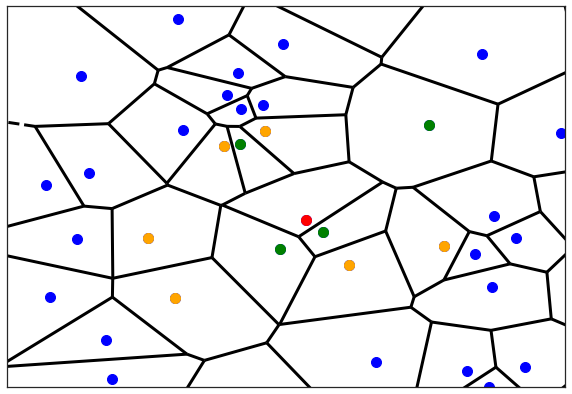

In [ ]:
try:
    x = x[:,:2]
    x = x.numpy()
except:
    pass

#point closest to center
center_dists = np.sum(x**2, axis=1)
center_idx = np.argmin(center_dists)
center_point = x[center_idx]

vor = Voronoi(x)

custom_params = {"axes.spines.right": True, "axes.spines.top": True,
                  "axes.labelsize": fontsize, "xtick.labelsize": fontsize,"ytick.labelsize": fontsize,
                  "legend.fontsize": fontsize, "legend.title_fontsize": fontsize,
                "lines.linewidth": 3, "figure.figsize": (10, 8),}
sns.set_theme(style="ticks", rc=custom_params)

fig, ax = plt.subplots(figsize=(10, 7))
voronoi_plot_2d(vor, ax = ax, show_vertices=False, line_colors='black',linestyle='dashed', line_width=3, line_alpha=1, point_size=10, show_points=False)
ax.plot(x[:, 0], x[:, 1], 'o', c='blue', markersize=10)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(-6, 6)
ax.set_ylim(-6, 6)

plt.plot(x[:, 0], x[:, 1], 'o', color='blue')    
right_neighbours0 = idx[center_idx][z_mask_s0[center_idx]!=0]
right_neighbours1 = idx[center_idx][z_mask_s1[center_idx]!=0]
right_neighbours1 = right_neighbours1[np.in1d(right_neighbours1, right_neighbours0, invert=True)]
plt.plot(x[right_neighbours0, 0], x[right_neighbours0, 1], 'o', color='green', markersize=10)   
plt.plot(x[right_neighbours1, 0], x[right_neighbours1, 1], 'o', color='orange', markersize=10)
plt.plot(center_point[0], center_point[1], 'o', color='red', markersize=10)
plt.show()

folder = incomp_folder + "Results/"

save_fig(fig, "voronoi_dont_use", folder)

### In vitro speed comparisons

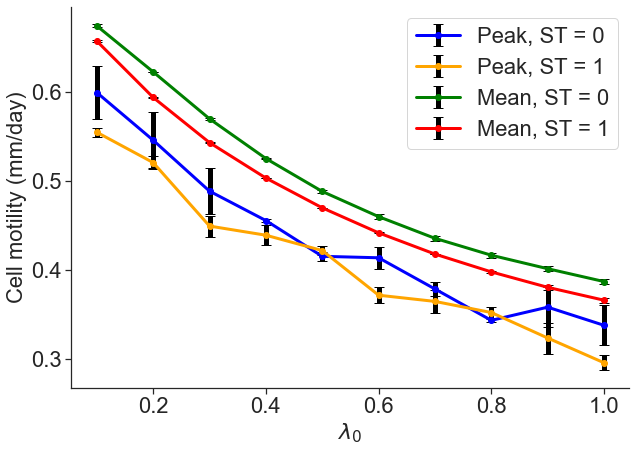

In [5]:
# Making plot ensuring that eta=0.2 is ok for most m_l0 vals

val_lst_st0 = []
std_lst_st0 = []

val_lst_st1 = []
std_lst_st1 = []

mean_lst_st0 = []
mean_lst_st1 = []

mean_std_lst_st0 = []
mean_std_lst_st1 = []

ml0_lst        = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
st_lst         = [0, 1]

for st in st_lst:
    for ml0 in ml0_lst:
        if st == 0:
            folder = f'new_data/vitro_speed_diff_ml0/noise_0.2_ml0_{ml0}_st_0/data.npy'
        else:
            folder = f'new_data/vitro_speed_diff_ml0/noise_0.2_ml0_{ml0}_st_1/data.npy'
        
        data = np.load(folder, allow_pickle=True)
        mask_lst, x_lst, p_lst, q_lst = data

        x_lst_exp = [x_lst[i][None] for i in range(len(x_lst))]
        x_arr = np.concatenate(x_lst_exp, axis=0)
        x0, x1, x2 = x_arr[100:130], x_arr[130:160], x_arr[160:190]
        x_lst = [x0, x1, x2]
        speeds     = [np.linalg.norm(x_arr[1:] - x_arr[:-1], axis=2) * 5 / (10/1440) * 0.001 for x_arr in x_lst]
        #means
        mean0 = speeds[0].mean()
        mean1 = speeds[1].mean()
        mean2 = speeds[2].mean()
        mean_mean = (mean0 + mean1 + mean2) / 3
        mean_std  = np.array([mean0, mean1, mean2]).std()
        #make histograms and center bins
        vals0, bins0 = np.histogram(speeds[0].flatten(), bins=100, density=False)
        bins0 = 0.5*(bins0[1:] + bins0[:-1])
        vals1, bins1 = np.histogram(speeds[1].flatten(), bins=100, density=False)
        bins1 = 0.5*(bins1[1:] + bins1[:-1])
        vals2, bins2 = np.histogram(speeds[2].flatten(), bins=100, density=False)
        bins2 = 0.5*(bins2[1:] + bins2[:-1])



        #max vals
        max_val0 = bins0[np.argmax(vals0)]
        max_val1 = bins1[np.argmax(vals1)]
        max_val2 = bins2[np.argmax(vals2)]

        max_val_lst = [max_val0, max_val1, max_val2]
        max_val_lst = np.array(max_val_lst)

        if st == 0:
            val_lst_st0.append(max_val_lst.mean())
            std_lst_st0.append(max_val_lst.std())
            mean_lst_st0.append(mean_mean)
            mean_std_lst_st0.append(mean_std)
        else:
            val_lst_st1.append(max_val_lst.mean())
            std_lst_st1.append(max_val_lst.std())
            mean_lst_st1.append(mean_mean)
            mean_std_lst_st1.append(mean_std)


fig, ax = plt.subplots(figsize=(10, 7))
plt.errorbar(ml0_lst, val_lst_st0, yerr=std_lst_st0, label='Peak, ST = 0', c='blue', fmt='o-', ecolor='black', capsize=5, elinewidth=5)
plt.errorbar(ml0_lst, val_lst_st1, yerr=std_lst_st1, label='Peak, ST = 1', c='orange', fmt='o-', ecolor='black', capsize=5, elinewidth=5)
plt.errorbar(ml0_lst, mean_lst_st0, yerr=mean_std_lst_st0, label='Mean, ST = 0', c='green', fmt='o-', ecolor='black', capsize=5, elinewidth=5)
plt.errorbar(ml0_lst, mean_lst_st1, yerr=mean_std_lst_st1, label='Mean, ST = 1', c='red', fmt='o-', ecolor='black', capsize=5, elinewidth=5)
plt.xlabel('$\lambda_0$')
plt.ylabel('Cell motility (mm/day)')
plt.legend()
plt.show();

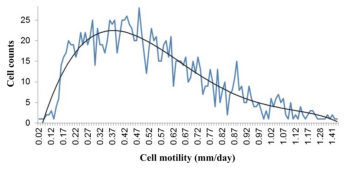

In [6]:
#Image from paper 
from PIL import Image

def open_image_local(path_to_image):
    image = Image.open(path_to_image) # Open the image
    image_array = np.array(image) # Convert to a numpy array
    return image_array # Output

folder = incomp_folder + "Results/vitro_comparison.jpg"
myImage = open_image_local(folder);
myImage = np.array(myImage)
plt.imshow(myImage[40:380, 0:])
plt.axis('off');

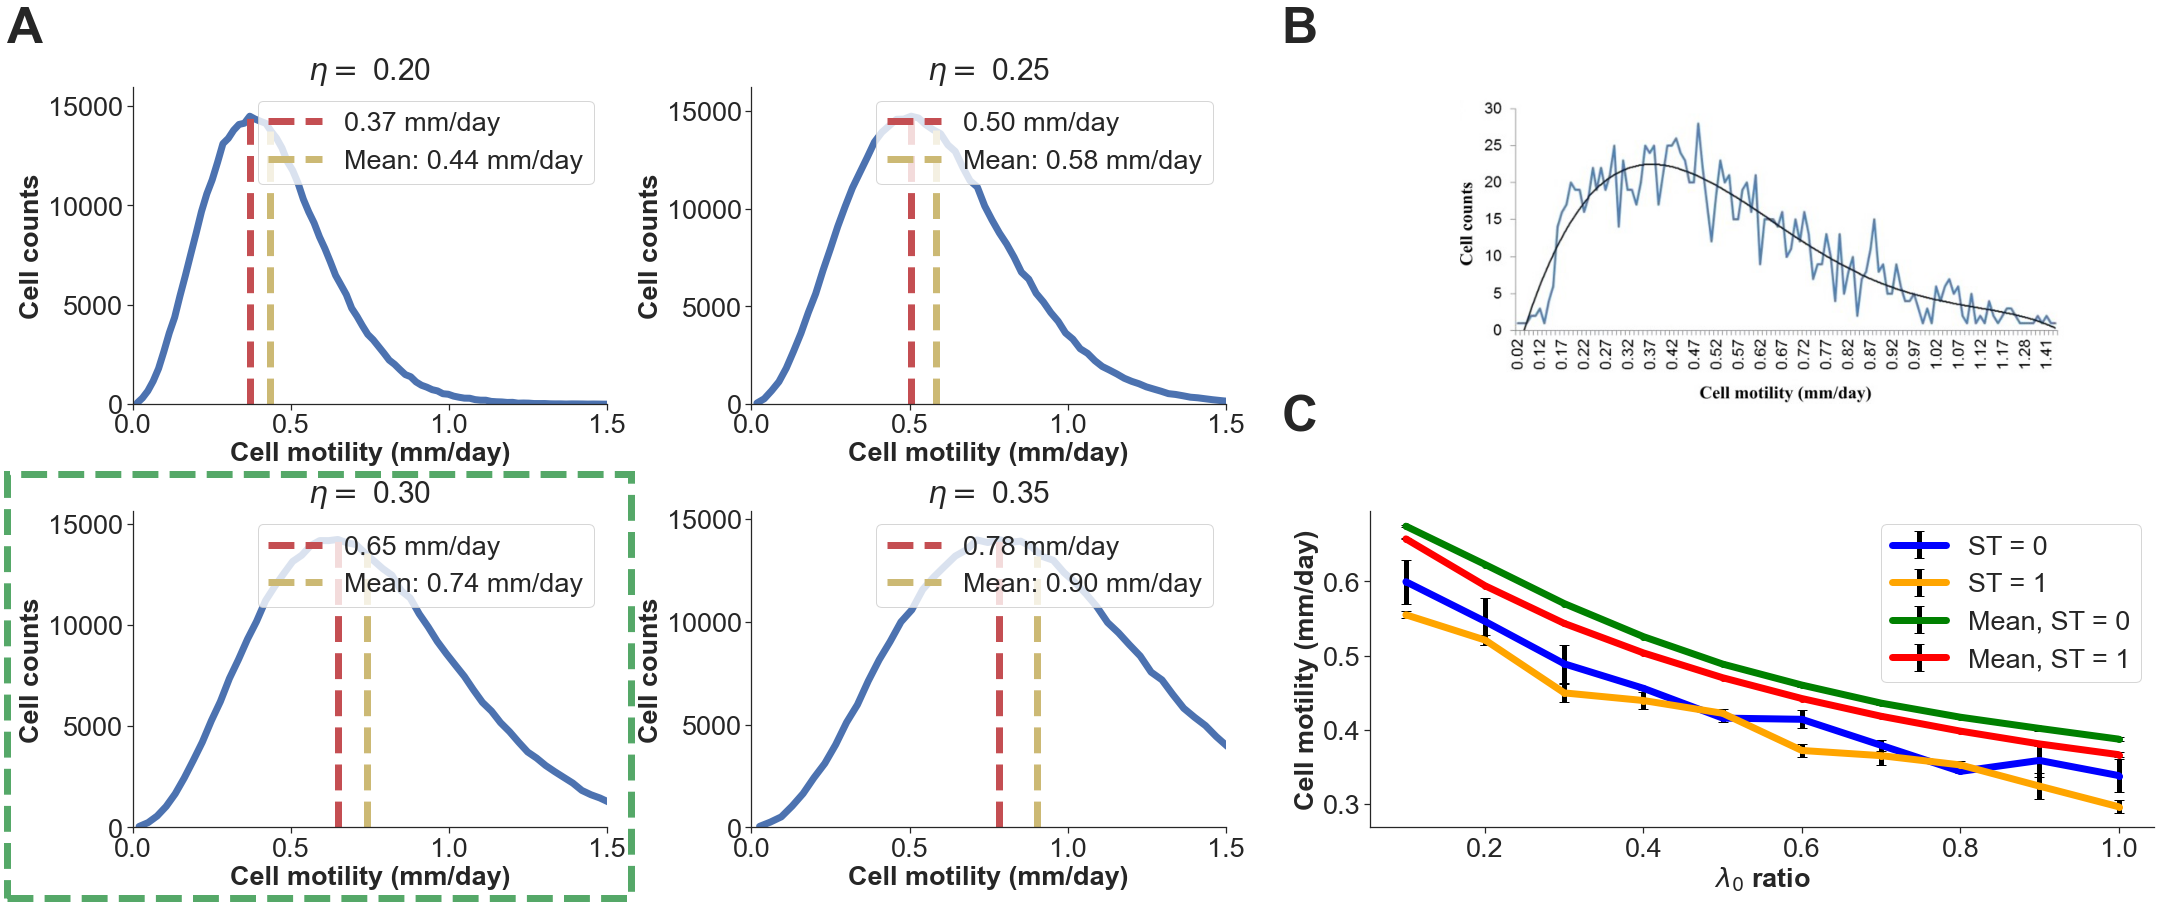

In [7]:
# Making actual plot
# Adding means to the plots

fontsize = 27

custom_params = {"axes.spines.right": False, "axes.spines.top": False,
                  "axes.labelsize": fontsize, "xtick.labelsize": fontsize,
                  "ytick.labelsize": fontsize,
                  "legend.fontsize": fontsize, "legend.title_fontsize": fontsize,
                  "lines.linewidth": 7, "figure.figsize": (8, 6), "axes.titlesize": fontsize+3}

sns.set_theme(style="ticks", rc=custom_params)

gs = mpl.gridspec.GridSpec(4, 7)

### Making speedplots for vitro
noise_lvls_lst = np.linspace(0.1,0.4, num=31)  
fig = plt.figure(figsize=(30, 12), tight_layout=True)
pic_ax = fig.add_subplot(gs[:-2, 4:])
pic_ax.imshow(myImage)
pic_ax.axis('off')

pic_box = pic_ax.get_position()
pic_box.y0 = pic_box.y0 + 0.5
pic_box.y1 = pic_box.y1 + 0.5
pic_ax.set_position(pic_box)

fit_ax = fig.add_subplot(gs[-2:, 4:])

ax = [fig.add_subplot(gs[:2, :2]), fig.add_subplot(gs[:2, 2:4]) ,fig.add_subplot(gs[2:4, :2]), fig.add_subplot(gs[2:4, 2:4])]
ml = 0.7

for i,eta_idx in enumerate([10, 15, 20, 25]):
  eta_val = noise_lvls_lst[eta_idx]
  test_folder = f'new_data/vitro_speed_ml7/noise_{noise_lvls_lst[eta_idx]:.2f}_ml0_{ml}/data.npy'
  data = np.load(test_folder, allow_pickle=True)
  mask_lst, x_lst, p_lst, q_lst = data

  x_lst_exp = [x_lst[i][None] for i in range(len(x_lst))]
  x_arr = np.concatenate(x_lst_exp, axis=0)
  x_arr = x_arr[100:]

  speeds = np.linalg.norm(x_arr[1:] - x_arr[:-1], axis=2) * 5 / (10/1440) * 0.001
  mean   = np.mean(speeds)


  #make histogram and center bins
  vals, bins = np.histogram(speeds.flatten(), bins=100, density=False)
  bin_centers = 0.5*(bins[1:] + bins[:-1])
  mean_bin = np.argmin(np.abs(bin_centers - mean))

  #find maximum value
  max_val = vals.max()
  max_idx = np.where(vals == max_val)

  ax[i].plot(bin_centers, vals)
  ax[i].set_ylim(0, max_val*1.1)
  ax[i].set_xlim(0, 1.5)
  # Arrow from maximum to x axis
  ax[i].vlines(bin_centers[max_idx], 0, max_val, colors='r', linestyles='dashed', label=f'{bin_centers[max_idx][0]:.2f} mm/day')
  ax[i].vlines(mean, 0, vals[mean_bin], colors='y', linestyles='dashed', label=f'Mean: {mean:.2f} mm/day')
  ax[i].set_ylabel('Cell counts', weight='bold')
  ax[i].set_xlabel('Cell motility (mm/day)', weight='bold')
  ax[i].set_title(f'$\eta = $ {eta_val:.2f}')
  legend_properties = {'weight':'bold'}
  ax[i].legend(loc='upper right')




# Add the patch to the Axes
fig.patches.extend([plt.Rectangle((0.00,0.01),0.289,0.49,
                                  fill=True, edgecolor='g', alpha=1,
                                  transform=fig.transFigure, figure=fig, facecolor='none',
                                  lw=7, ls='--')])

val_lst_st0 = []
std_lst_st0 = []

val_lst_st1 = []
std_lst_st1 = []

mean_lst_st0 = []
mean_lst_st1 = []

mean_std_lst_st0 = []
mean_std_lst_st1 = []

ml0_lst        = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
st_lst         = [0, 1]

for st in st_lst:
    for ml0 in ml0_lst:
        if st == 0:
            folder = f'new_data/vitro_speed_diff_ml0/noise_0.2_ml0_{ml0}_st_0/data.npy'
        else:
            folder = f'new_data/vitro_speed_diff_ml0/noise_0.2_ml0_{ml0}_st_1/data.npy'
        
        data = np.load(folder, allow_pickle=True)
        mask_lst, x_lst, p_lst, q_lst = data

        x_lst_exp = [x_lst[i][None] for i in range(len(x_lst))]
        x_arr = np.concatenate(x_lst_exp, axis=0)
        x0, x1, x2 = x_arr[100:130], x_arr[130:160], x_arr[160:190]
        x_lst = [x0, x1, x2]
        speeds     = [np.linalg.norm(x_arr[1:] - x_arr[:-1], axis=2) * 5 / (10/1440) * 0.001 for x_arr in x_lst]

        #means
        mean0 = speeds[0].mean()
        mean1 = speeds[1].mean()
        mean2 = speeds[2].mean()
        mean_mean = (mean0 + mean1 + mean2) / 3
        mean_std  = np.array([mean0, mean1, mean2]).std()

        #make histograms and center bins
        vals0, bins0 = np.histogram(speeds[0].flatten(), bins=100, density=False)
        bins0 = 0.5*(bins0[1:] + bins0[:-1])
        vals1, bins1 = np.histogram(speeds[1].flatten(), bins=100, density=False)
        bins1 = 0.5*(bins1[1:] + bins1[:-1])
        vals2, bins2 = np.histogram(speeds[2].flatten(), bins=100, density=False)
        bins2 = 0.5*(bins2[1:] + bins2[:-1])


        #max vals
        max_val0 = bins0[np.argmax(vals0)]
        max_val1 = bins1[np.argmax(vals1)]
        max_val2 = bins2[np.argmax(vals2)]

        max_val_lst = [max_val0, max_val1, max_val2]
        max_val_lst = np.array(max_val_lst)

        if st == 0:
            val_lst_st0.append(max_val_lst.mean())
            std_lst_st0.append(max_val_lst.std())
            mean_lst_st0.append(mean_mean)
            mean_std_lst_st0.append(mean_std)
        else:
            val_lst_st1.append(max_val_lst.mean())
            std_lst_st1.append(max_val_lst.std())
            mean_lst_st1.append(mean_mean)
            mean_std_lst_st1.append(mean_std)


fit_ax.errorbar(ml0_lst, val_lst_st0, yerr=std_lst_st0, label='ST = 0', c='blue', fmt='o-', ecolor='black', capsize=5, elinewidth=5)
fit_ax.errorbar(ml0_lst, val_lst_st1, yerr=std_lst_st1, label='ST = 1', c='orange', fmt='o-', ecolor='black', capsize=5, elinewidth=5)
fit_ax.errorbar(ml0_lst, mean_lst_st0, yerr=mean_std_lst_st0, label='Mean, ST = 0', c='green', fmt='o-', ecolor='black', capsize=5, elinewidth=5)
fit_ax.errorbar(ml0_lst, mean_lst_st1, yerr=mean_std_lst_st1, label='Mean, ST = 1', c='red', fmt='o-', ecolor='black', capsize=5, elinewidth=5)
fit_ax.set_xlabel('$\lambda_0$ ratio', weight='bold')
fit_ax.set_ylabel('Cell motility (mm/day)', weight='bold')
fit_ax.legend(loc='upper right')

fig.text(0.0, 1, "A", size=50, weight='bold')
fig.text(0.59, 1, "B", size=50, weight='bold')
fig.text(0.59, 0.55, "C", size=50, weight='bold')


folder = main_folder + "Results/"
# plt.show()
# save_fig(fig, f"vitro_speed_comp", folder)


In [27]:
save_fig(fig, f"vitro_speed_comp", folder)

### Making gridsearch plots

In [3]:
# Getting data
noise_lvl   = 0.2
m_l0_lst    = [0.2, 0.4, 0.6, 0.8, 0.9]
m_conc_lst  = [0.2, 0.4, 0.6, 0.65, 0.7, 0.75, 0.8, 0.9]
m_conc_sub_lst = [0.65, 0.7, 0.75]
seethru_lst = [0, 1]
seethru = seethru_lst[0]

In [28]:
st0_arr = np.zeros((5, 8))
st1_arr = np.zeros((5, 8))
threshold = 10
for m_l0 in m_l0_lst:
    for mconc in m_conc_lst:
        for seethru in seethru_lst:
            folder = f"vitro_data/vitro_clusters_gridsearch/seethru_{seethru}_noise_{noise_lvl}_ml0_{m_l0}_mconc_{mconc}/data.npy"
            data = np.load(folder, allow_pickle=True)
            mask_lst, x_lst, p_lst, q_lst = data
            if mconc in m_conc_sub_lst:
                p_mask = mask_lst[9]
                x = x_lst[9]
                p = p_lst[9]
            else:    
                p_mask = mask_lst[12]
                x = x_lst[12]
                p = p_lst[12]
            num_clusters = get_num_clusters(x, seethru=0, p_mask=p_mask, threshold=threshold)
            if seethru == 0:
                st0_arr[m_l0_lst.index(m_l0), m_conc_lst.index(mconc)] = num_clusters
            else:
                st1_arr[m_l0_lst.index(m_l0), m_conc_lst.index(mconc)] = num_clusters


In [30]:
st0_arr = np.flip(st0_arr, axis=0)
st0_arr = np.flip(st0_arr, axis=1)

st1_arr = np.flip(st1_arr, axis=0)
st1_arr = np.flip(st1_arr, axis=1)

cmap = 'viridis'

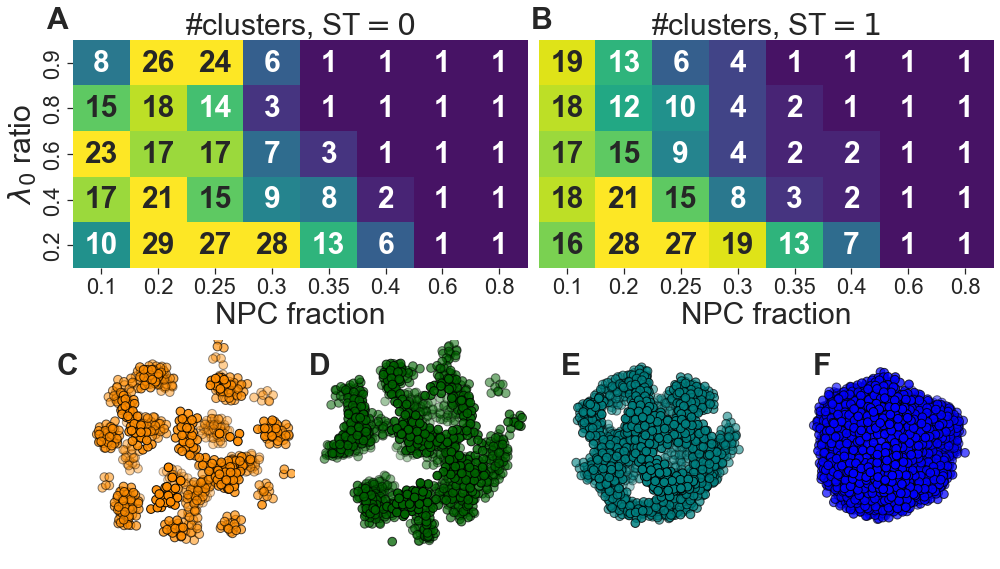

In [151]:
fig = plt.figure(figsize=(14,8), tight_layout=True) #plt.subplots(figsize=(12,8), tight_layout=True)
gs = mpl.gridspec.GridSpec(2, 8)

st0_ax = fig.add_subplot(gs[0, 0:4])

sns.heatmap(st0_arr, annot=True, xticklabels=np.flip(np.round(1.-np.array(m_conc_lst),2)), yticklabels=np.flip(np.array(m_l0_lst)),
             annot_kws={"fontsize":30, "weight": "bold" }, cbar=False, cmap=cmap ,vmin=0, vmax=20, ax=st0_ax)  
st0_ax.set_xlabel("NPC fraction", fontsize=30)
st0_ax.set_ylabel("$\lambda_0$ ratio", fontsize=30)
st0_ax.set_title('#clusters, ST$= 0$', fontsize=30)


st1_ax = fig.add_subplot(gs[0, 4:8])
sns.heatmap(st1_arr, annot=True, xticklabels=np.flip(np.round(1.-np.array(m_conc_lst),2)), yticklabels=np.flip(np.array(m_l0_lst)),
             annot_kws={"fontsize":30, "weight": "bold" }, cbar=False, cmap=cmap ,vmin=0, vmax=20, ax=st1_ax)  
st1_ax.set_xlabel("NPC fraction", fontsize=30)
st1_ax.set_title('#clusters, ST$= 1$', fontsize=30)
st1_ax.set_ylabel("", fontsize=30)
st1_ax.set_yticks([])


orange_ax = fig.add_subplot(gs[1, 0:2], projection='3d')
orange_ax.set_axis_off()
green_ax = fig.add_subplot(gs[1, 2:4], projection='3d')
green_ax.set_axis_off()
teal_ax  = fig.add_subplot(gs[1, 4:6], projection='3d')
teal_ax.set_axis_off()
blue_ax = fig.add_subplot(gs[1, 6:8], projection='3d')
blue_ax.set_axis_off()


# Scatterplot 

seethru     = 0
noise_lvl   = 0.2
m_l0        = 0.4
mconc       = 0.8
folder      = f"vitro_data/vitro_clusters_gridsearch/seethru_{seethru}_noise_{noise_lvl}_ml0_{m_l0}_mconc_{mconc}/data.npy"

data = np.load(folder, allow_pickle=True)
mask_lst, x_lst, p_lst, q_lst = data
p_mask = mask_lst[12]
x = x_lst[12]
polar_x = x[p_mask == 1]

orange_ax.scatter(polar_x[:, 0], polar_x[:, 1], polar_x[:, 2], s=75, edgecolors='black', c='darkorange', depthshade=True)
orange_ax.set_xlim(-15, 15)
orange_ax.set_ylim(-15, 15)
orange_ax.set_zlim(-15, 15)
orange_ax.axes.set_aspect('equal')


seethru     = 0
noise_lvl   = 0.2
m_l0        = 0.4
mconc       = 0.7
folder      = f"vitro_data/vitro_clusters_gridsearch/seethru_{seethru}_noise_{noise_lvl}_ml0_{m_l0}_mconc_{mconc}/data.npy"

data = np.load(folder, allow_pickle=True)
mask_lst, x_lst, p_lst, q_lst = data
p_mask = mask_lst[9]
x = x_lst[9]
polar_x = x[p_mask == 1]

green_ax.scatter(polar_x[:, 0], polar_x[:, 1], polar_x[:, 2], s=75, edgecolors='black', c='darkgreen', depthshade=True)
green_ax.set_xlim(-15, 15)
green_ax.set_ylim(-15, 15)
green_ax.set_zlim(-15, 15)
green_ax.axes.set_aspect('equal')

seethru     = 0
noise_lvl   = 0.2
m_l0        = 0.6
mconc       = 0.6
folder      = f"vitro_data/vitro_clusters_gridsearch/seethru_{seethru}_noise_{noise_lvl}_ml0_{m_l0}_mconc_{mconc}/data.npy"

data = np.load(folder, allow_pickle=True)
mask_lst, x_lst, p_lst, q_lst = data
p_mask = mask_lst[12]
x = x_lst[12]
polar_x = x[p_mask == 1]

teal_ax.scatter(polar_x[:, 0], polar_x[:, 1], polar_x[:, 2], s=75, edgecolors='black', c='teal', depthshade=True)
teal_ax.set_xlim(-15, 15)
teal_ax.set_ylim(-15, 15)
teal_ax.set_zlim(-15, 15)
teal_ax.axes.set_aspect('equal')

seethru     = 0
noise_lvl   = 0.2
m_l0        = 0.8
mconc       = 0.4
folder      = f"vitro_data/vitro_clusters_gridsearch/seethru_{seethru}_noise_{noise_lvl}_ml0_{m_l0}_mconc_{mconc}/data.npy"

data = np.load(folder, allow_pickle=True)
mask_lst, x_lst, p_lst, q_lst = data
p_mask = mask_lst[12]
x = x_lst[12]
polar_x = x[p_mask == 1]

blue_ax.scatter(polar_x[:, 0], polar_x[:, 1], polar_x[:, 2], s=75, edgecolors='black', c='blue', depthshade=True)
blue_ax.set_xlim(-15, 15)
blue_ax.set_ylim(-15, 15)
blue_ax.set_zlim(-15, 15)
blue_ax.axes.set_aspect('equal')

fig.text(0.05, 0.95, "A", size=30, weight='bold')
fig.text(0.53, 0.95, "B", size=30, weight='bold')
fig.text(0.06, 0.35, "C", fontsize=30, weight='bold')
fig.text(0.31, 0.35, "D", fontsize=30, weight='bold')
fig.text(0.56, 0.35, "E", fontsize=30, weight='bold')
fig.text(0.81, 0.35, "F", fontsize=30, weight='bold')

#saving figure
folder = main_folder + "Results/"
save_fig(fig, f"vitro_cluster_heatmap", folder)

### Make ST=0 and ST=1 comparison plot

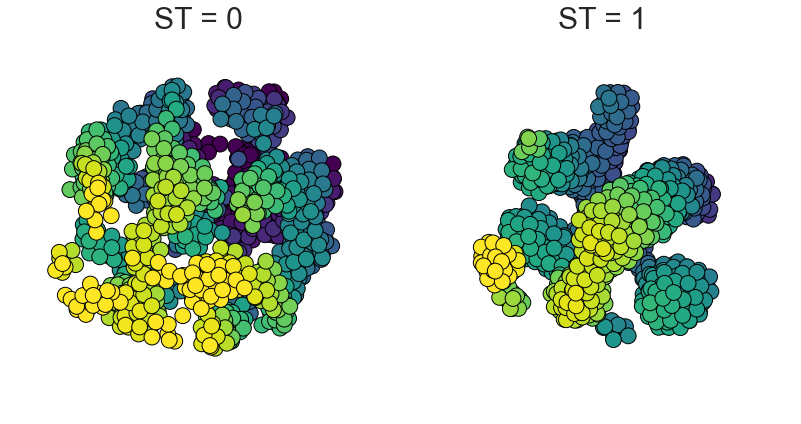

In [ ]:
fig, ax = plt.subplots(1,2 ,figsize=(12, 6), tight_layout=True, subplot_kw=dict(projection='3d'))
ax = ax.flatten()

seethru     = 0
noise_lvl   = 0.2
m_l0        = 0.6
mconc       = 0.7
folder      = f"vitro_data/vitro_clusters_gridsearch/seethru_{seethru}_noise_{noise_lvl}_ml0_{m_l0}_mconc_{mconc}/data.npy"

data = np.load(folder, allow_pickle=True)
mask_lst, x_lst, p_lst, q_lst = data
p_mask = mask_lst[9]
x = x_lst[9]
polar_x = x[p_mask == 1]

cm = plt.get_cmap("viridis")
cNorm = mpl.colors.Normalize(vmin=-15, vmax=15)
scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cm)
scalarMap.set_array([])
colors = scalarMap.to_rgba(-polar_x[:, 1])

ax[0].set_axis_off()
ax[0].scatter(polar_x[:, 0], polar_x[:, 1], polar_x[:, 2], s=250, c=colors ,alpha=1, edgecolors='black')
ax[0].set_xlim(-15, 15)
ax[0].set_ylim(-15, 15)
ax[0].set_zlim(-15, 15)
ax[0].axes.set_aspect('equal')
ax[0].set_title('ST = 0', fontsize=30)

seethru     = 1
noise_lvl   = 0.2
m_l0        = 0.6
mconc       = 0.7
folder      = f"vitro_data/vitro_clusters_gridsearch/seethru_{seethru}_noise_{noise_lvl}_ml0_{m_l0}_mconc_{mconc}/data.npy"

data = np.load(folder, allow_pickle=True)
mask_lst, x_lst, p_lst, q_lst = data
p_mask = mask_lst[9]
x = x_lst[9]
polar_x = x[p_mask == 1]

colors = scalarMap.to_rgba(-polar_x[:, 1])
ax[1].set_axis_off()
ax[1].scatter(polar_x[:, 0], polar_x[:, 1], polar_x[:, 2], s=250, c=colors ,alpha=1, edgecolors='black')
ax[1].set_xlim(-15, 15)
ax[1].set_ylim(-15, 15)
ax[1].set_zlim(-15, 15)
ax[1].axes.set_aspect('equal')
ax[1].set_title('ST = 1', fontsize=30)

#saving figure
folder = main_folder + "Results/"

save_fig(fig, f"vitro_cluster_ST_comp", folder)